## Health Care for All Case Study using Pandas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50
## Install xlrd package to load Excel files
# conda install openpyxl
## conda install xlrd

In [2]:
RAND_STATE = 34 # for reproducible shuffling
TT_RATIO = 0.3 # test/train

In [3]:
from scipy.stats import iqr
def remove_outliers(df):
    for c in df.columns:
            pct_75 = np.percentile(df[c], 75)
            pct_25 = np.percentile(df[c], 25)
            upper_bound = pct_75 + 1.5*iqr(df[c])
            lower_bound = pct_25 - 1.5*iqr(df[c])
            condition = (df[c] < upper_bound) & (df[c] > lower_bound)
            df[c] = df[c][condition]  # Filter out the outliers
    return df

<b> We begin by loading the precleaned data set

In [4]:
hk_df= pd.read_csv("hk_df_cleaned.csv")

In [5]:
hk_df.columns # inspect the column names

Index(['index', 'state', 'gender', 'median_home_val', 'avg_fam_income',
       'avg_household_income', 'med_fam_income', 'median_household_income',
       'hvp1', 'per_capita_income', 'pobc2', 'avggift', 'domain', 'target_d',
       'med_fam_income_binned'],
      dtype='object')

<b> checking correlations between numerical variables

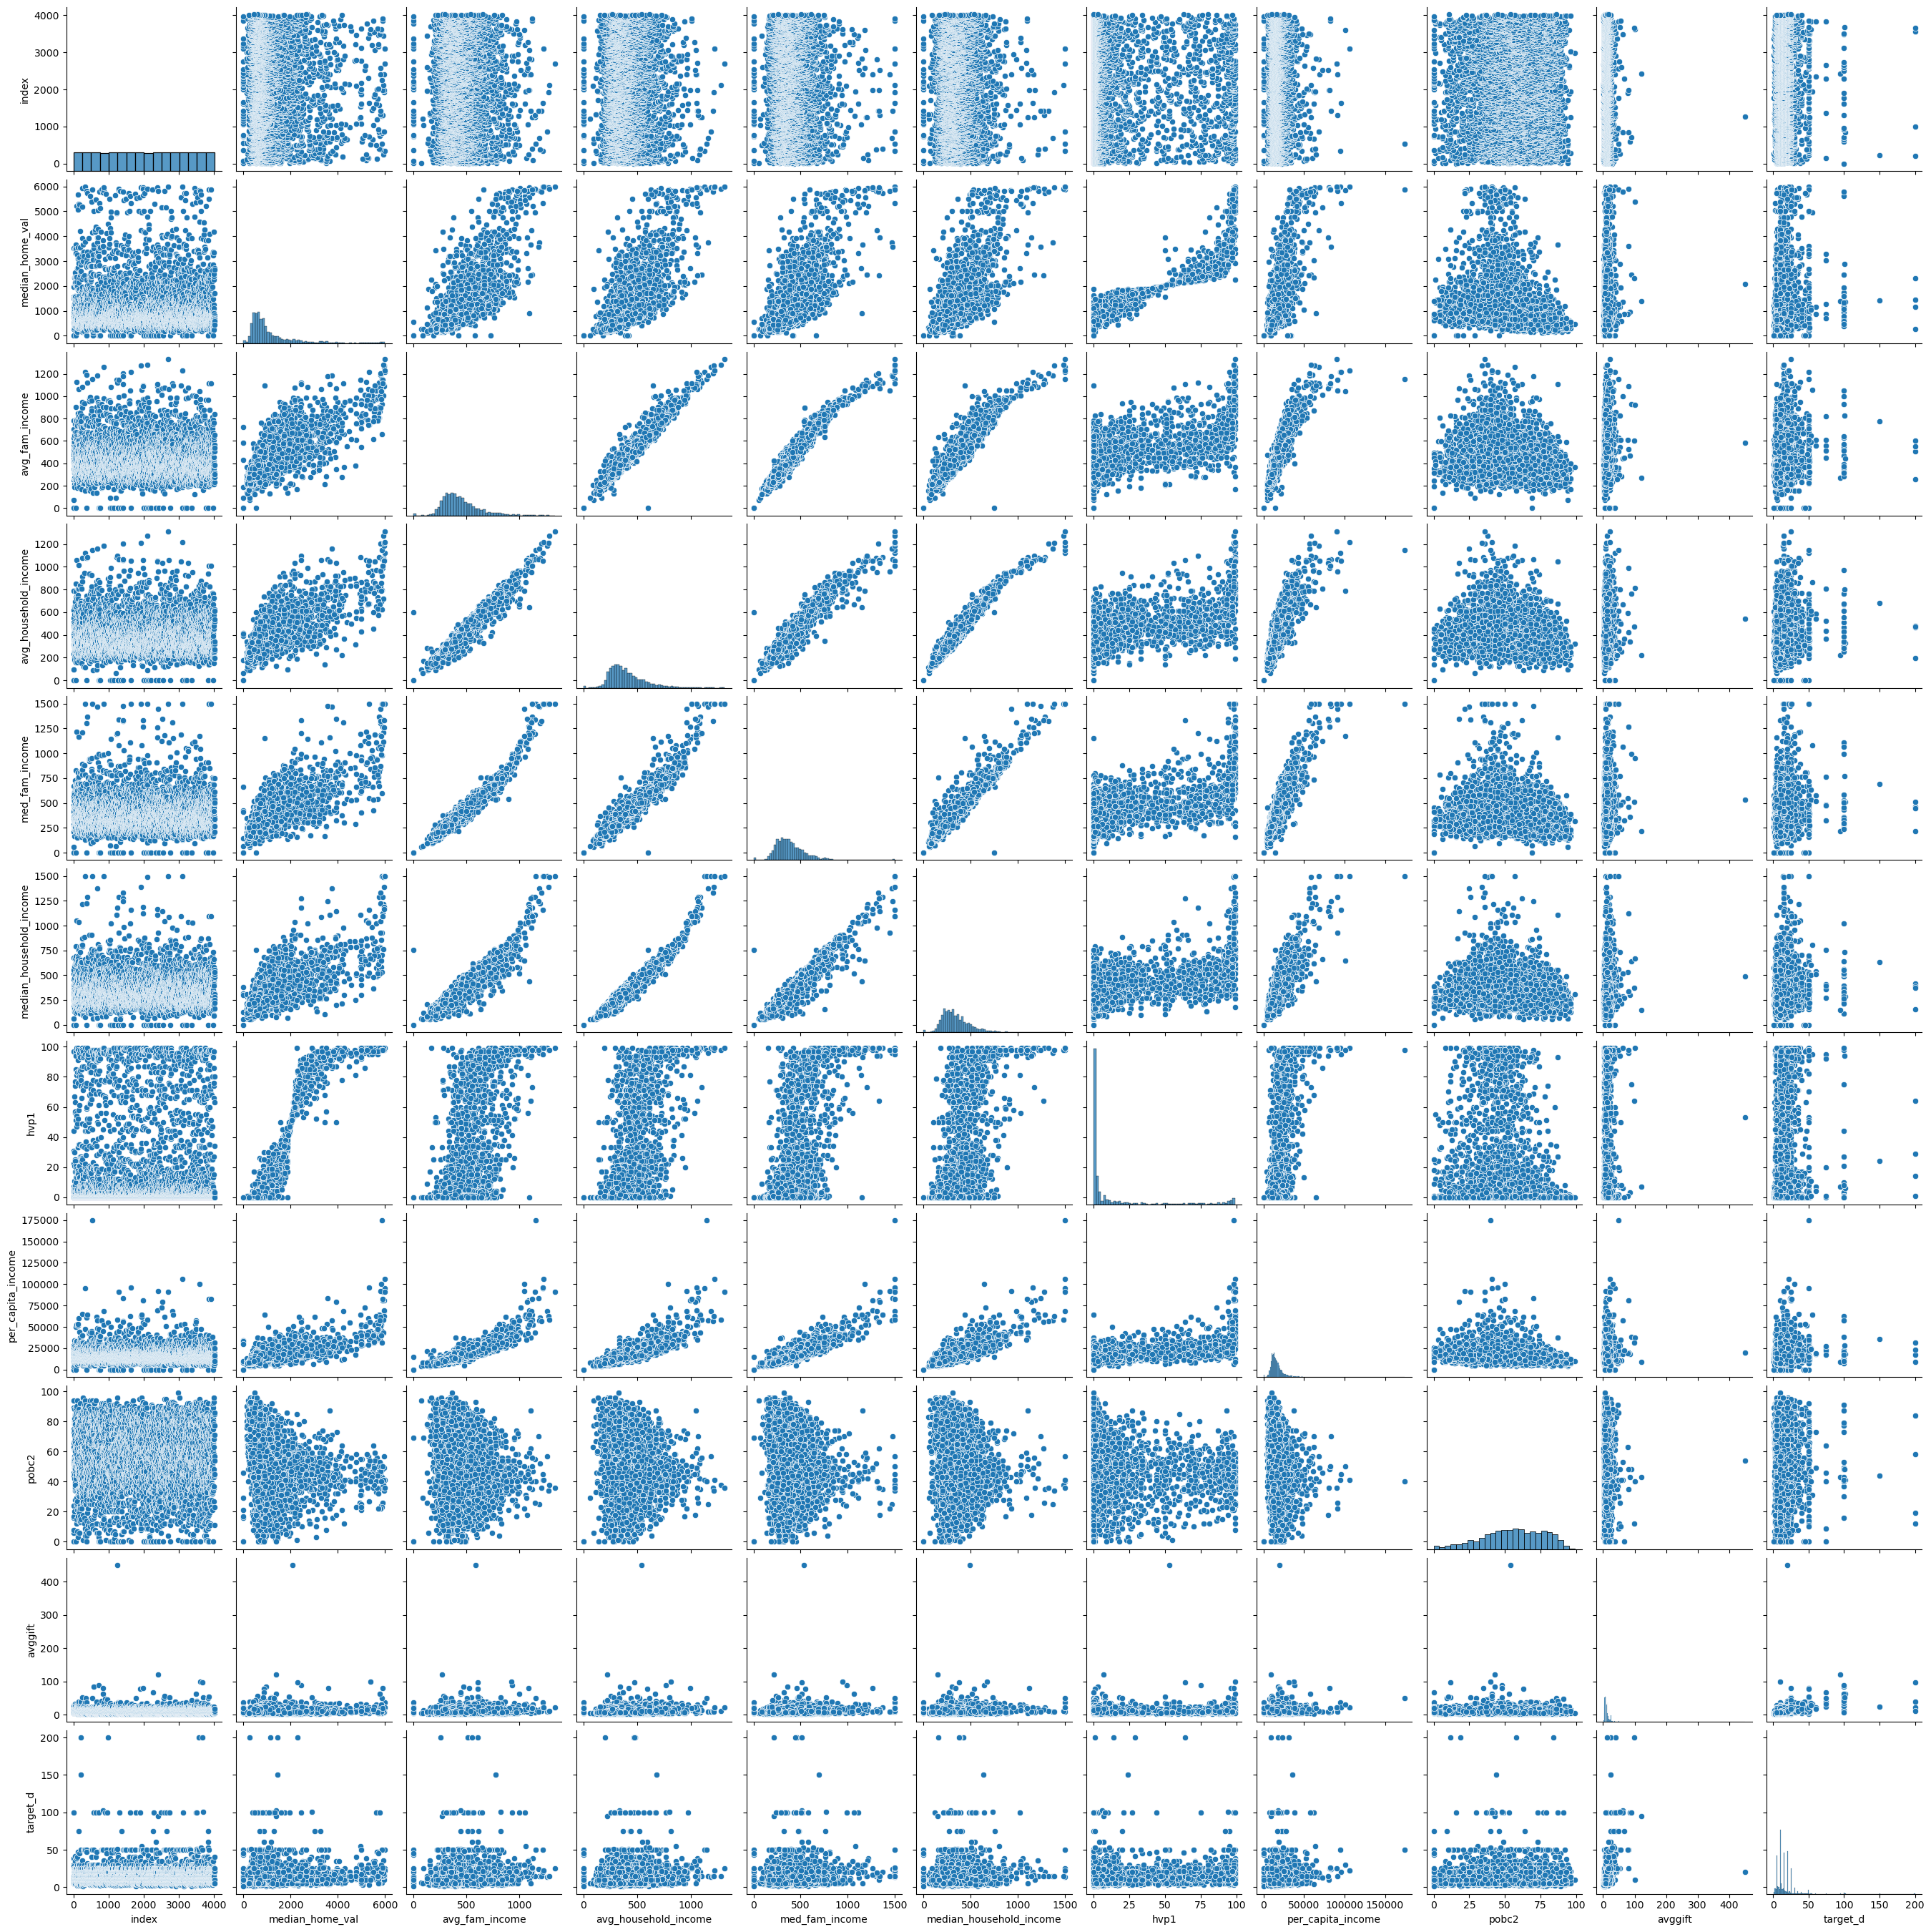

In [6]:
sns.pairplot(hk_df.select_dtypes(np.number)) # pairplot generates a grid of scatter plots for all numerical variables except on the diagonal where it displays distributions

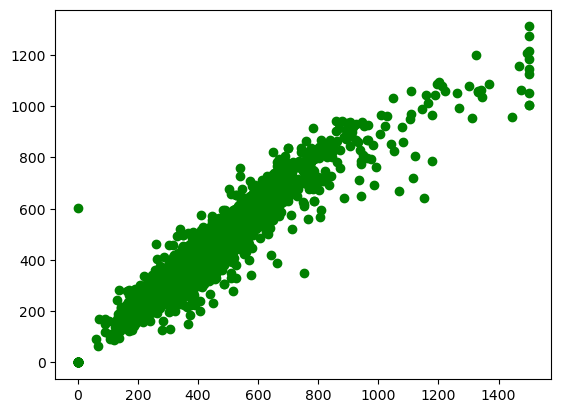

In [7]:
plt.scatter(x=hk_df['med_fam_income'], y=hk_df['avg_household_income'],c='g') # note the correlation between income sources


<b> Plotting the correlation heatmap

C:\Users\Aleks\AppData\Local\Temp\ipykernel_45152\3002754856.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = hk_df.corr()


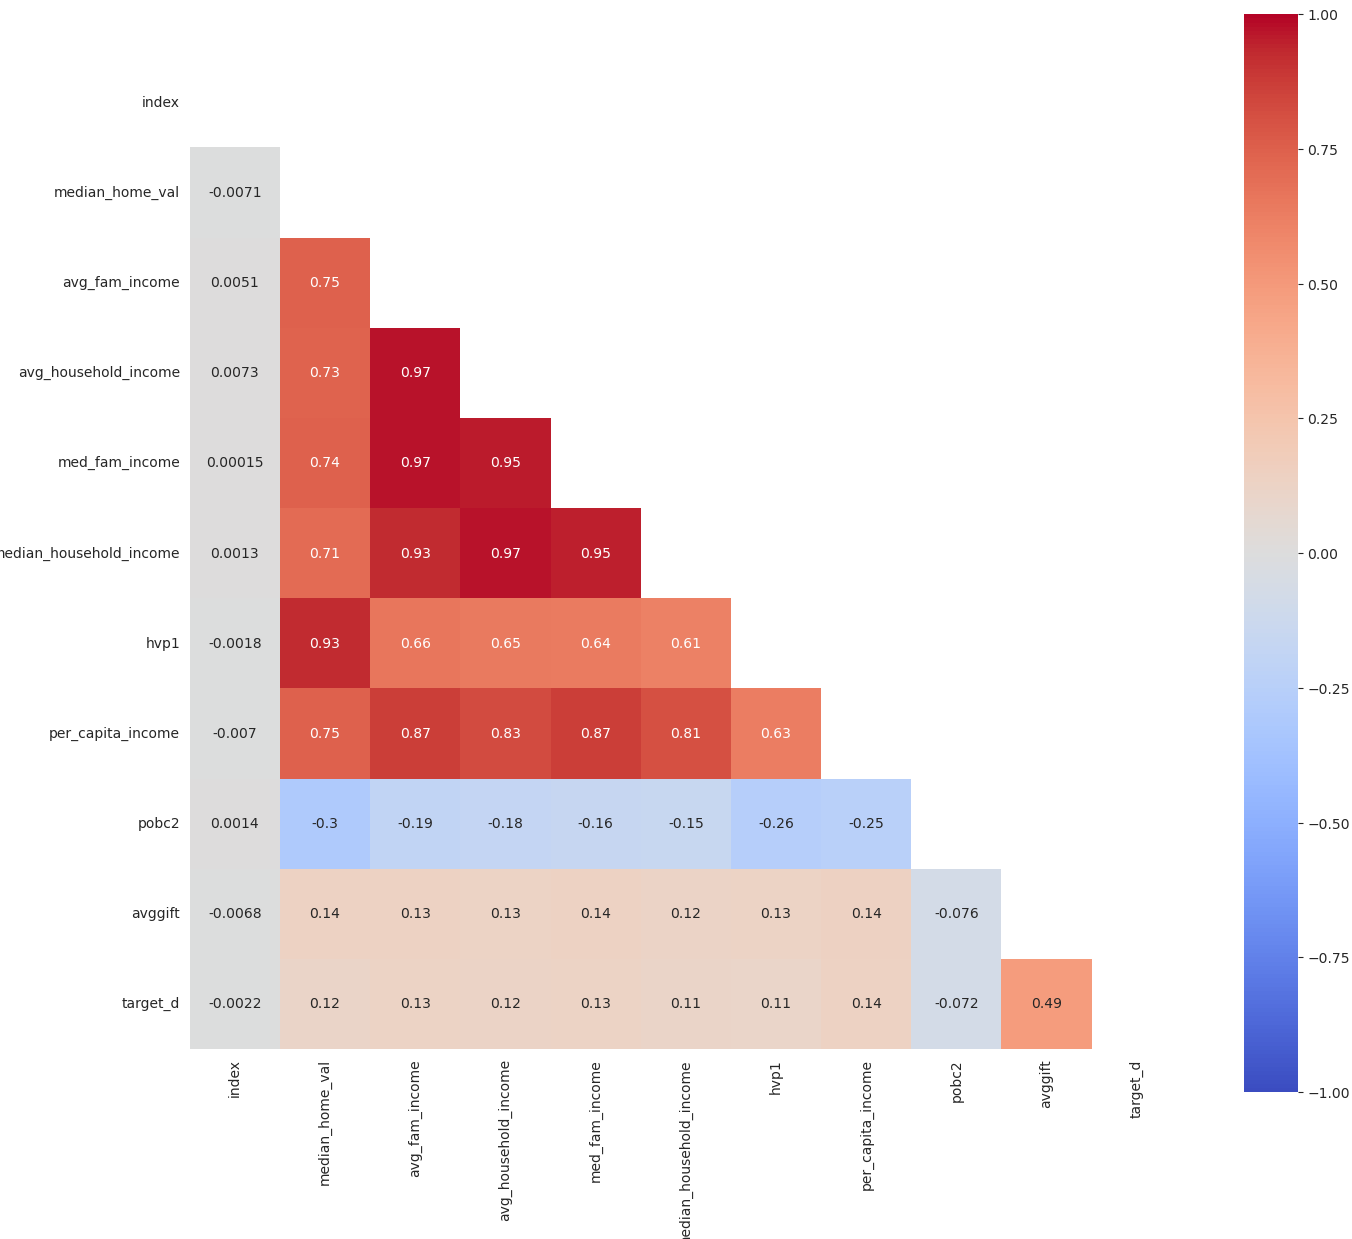

In [8]:
corr = hk_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True # trick to filter out the upper-right triangle, which is redundant due to symmetry
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 14))
    ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

<b> Removing highly correlated columns


In [9]:
CORR_THRESH = 0.80
corr_matrix=hk_df.corr().abs()
upper_triangle=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
corrd_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > CORR_THRESH)]
hk_df.drop(corrd_cols,axis=1,inplace=True)
hk_df.columns

C:\Users\Aleks\AppData\Local\Temp\ipykernel_45152\3145719619.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=hk_df.corr().abs()


Index(['index', 'state', 'gender', 'median_home_val', 'avg_fam_income',
       'pobc2', 'avggift', 'domain', 'target_d', 'med_fam_income_binned'],
      dtype='object')

array([[<Axes: title={'center': 'index'}>,
        <Axes: title={'center': 'median_home_val'}>],
       [<Axes: title={'center': 'avg_fam_income'}>,
        <Axes: title={'center': 'pobc2'}>],
       [<Axes: title={'center': 'avggift'}>,
        <Axes: title={'center': 'target_d'}>]], dtype=object)

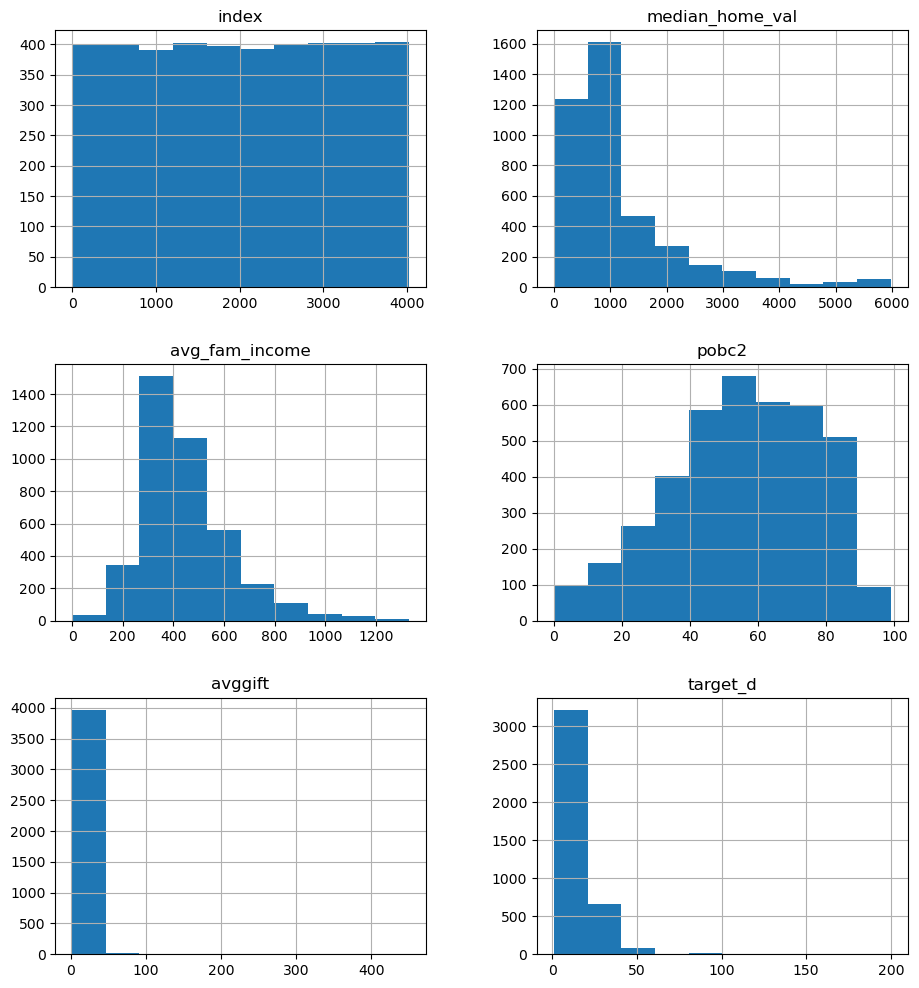

In [10]:
hk_df.hist(figsize=(11,12))

<b> Distribution of "median home value" is skewed towards lower incomes

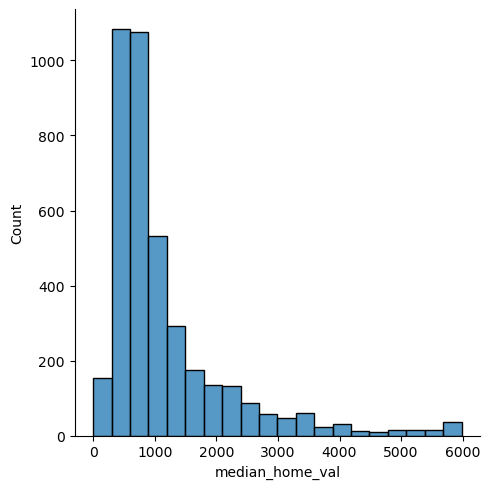

In [11]:
sns.displot((hk_df['median_home_val']), bins=20)

## X,y, one-hot, and test/train

In [12]:
X = hk_df.drop('target_d', axis=1)
y = hk_df.target_d

In [13]:
numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(object)

In [14]:
numericalX

,index,median_home_val,avg_fam_income,pobc2,avggift
0,0,1158.598192,520.0,16,28
1,1,537.000000,473.0,89,5
2,2,725.000000,436.0,17,4
3,3,1158.598192,413.0,74,27
4,4,995.000000,348.0,6,6
...,...,...,...,...,...
3986,4018,632.000000,388.0,71,8
3987,4019,595.000000,274.0,11,14
3988,4020,2707.000000,537.0,54,12
3989,4021,2666.000000,653.0,45,12


In [15]:
med=pd.DataFrame(hk_df.median_home_val)

In [16]:
y.isna().any()

False

array([[<Axes: title={'center': 'median_home_val'}>]], dtype=object)

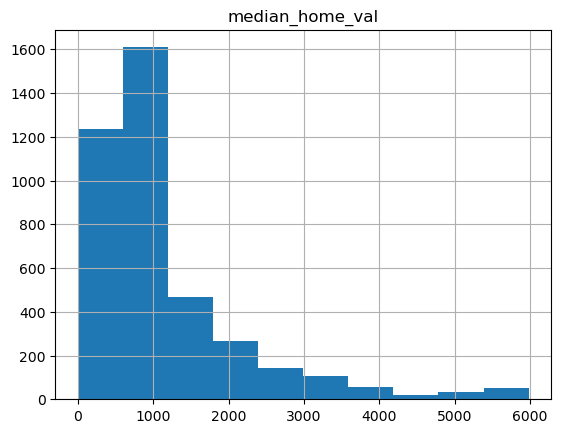

In [17]:
med.hist()

In [18]:
y.dropna(inplace=True)

In [19]:
y

0       100.0
1         7.0
2         5.0
3        38.0
4         5.0
        ...  
3986      5.0
3987     20.0
3988     22.0
3989     21.0
3990     25.0
Name: target_d, Length: 3991, dtype: float64

In [20]:
y = pd.DataFrame(y)

In [21]:
remove_outliers(pd.DataFrame(y))

,target_d
0,NaN
1,7.0
2,5.0
3,NaN
4,5.0
...,...
3986,5.0
3987,20.0
3988,22.0
3989,21.0


In [22]:
# one-hot encode the categorical features
X = pd.concat([pd.get_dummies(X[categoricalX.columns],drop_first=True),
               remove_outliers(X[numericalX.columns])],
              axis=1)

C:\Users\Aleks\AppData\Local\Temp\ipykernel_45152\504253479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c][condition]  # Filter out the outliers


In [23]:
X.isna().any()

state_AE           False
state_AK           False
state_AL           False
state_AP           False
state_AR           False
                   ...  
index              False
median_home_val     True
avg_fam_income      True
pobc2              False
avggift             True
Length: 77, dtype: bool

In [24]:
hk_df.columns

Index(['index', 'state', 'gender', 'median_home_val', 'avg_fam_income',
       'pobc2', 'avggift', 'domain', 'target_d', 'med_fam_income_binned'],
      dtype='object')

In [25]:
na_idcs = X[X.isna().any(axis=1)].index
X = pd.DataFrame(X).drop(na_idcs)
y = pd.DataFrame(y).drop(na_idcs)

In [26]:
na_idcs_y = y[y.isna().any(axis=1)].index
X = pd.DataFrame(X).drop(na_idcs_y)
y = pd.DataFrame(y).drop(na_idcs_y)

In [27]:
y.isna().any()

target_d    False
dtype: bool

In [28]:
# test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TT_RATIO, random_state=RAND_STATE)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.head(3)

,state_AE,state_AK,state_AL,state_AP,state_AR,state_AZ,state_Arizona,state_CA,state_CO,state_CT,...,domain_U3,domain_U4,med_fam_income_binned_Low,med_fam_income_binned_Moderate,med_fam_income_binned_Very High,index,median_home_val,avg_fam_income,pobc2,avggift
1288,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1304,675.0,427.0,69,6.0
3219,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,3251,684.0,375.0,75,15.0
2540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,2571,973.0,542.0,61,11.0


## Continuous transformations

<b> Power Transformer </b>: we use a power transformer to make the distribution of this variable more normal-like.  It improves modeling errors in linear regression.

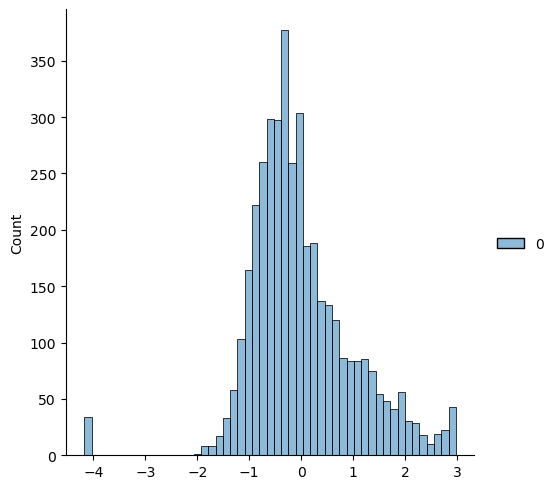

In [29]:
pt = PowerTransformer()
med_home_val_transformed=pt.fit_transform(hk_df['median_home_val'].to_numpy().reshape(-1,1))
sns.displot(med_home_val_transformed)

In [30]:
print("the parameters used to transform median_home_val are")
pt.get_params(),pt.lambdas_ # parameter used in the power transformation

the parameters used to transform median_home_val are


({'copy': True, 'method': 'yeo-johnson', 'standardize': True},
 array([0.24451556]))

In [31]:
X_train

,state_AE,state_AK,state_AL,state_AP,state_AR,state_AZ,state_Arizona,state_CA,state_CO,state_CT,...,domain_U3,domain_U4,med_fam_income_binned_Low,med_fam_income_binned_Moderate,med_fam_income_binned_Very High,index,median_home_val,avg_fam_income,pobc2,avggift
1288,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1304,675.0,427.0,69,6.0
3219,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,3251,684.0,375.0,75,15.0
2540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,2571,973.0,542.0,61,11.0
1813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1829,887.0,531.0,43,9.0
3341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,3373,696.0,430.0,67,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,396,581.0,411.0,57,10.0
3799,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,3831,2347.0,669.0,41,7.0
2271,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,2302,788.0,155.0,33,8.0
3051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,3083,1458.0,688.0,34,6.0


In [32]:
ct = ColumnTransformer([("pt", pt, list(numericalX.columns))],
                        remainder='drop', verbose=True).fit(X_train)
X_train_ct = pd.DataFrame(ct.transform(X_train))
X_test_ct = pd.DataFrame(ct.transform(X_test))

[ColumnTransformer] ............ (1 of 1) Processing pt, total=   0.1s


In [33]:
X_train_ct = pd.DataFrame(X_train_ct)
X_test_ct

,0,1,2,3,4
0,0.913157,-0.582495,0.791524,0.611232,-1.169286
1,1.270264,1.422511,0.102222,-0.473097,-0.833842
2,-0.907599,0.219938,0.289236,-1.877671,-0.266857
3,-0.834318,0.100576,0.281610,-0.091390,0.204423
4,-1.498420,1.347560,-0.290670,-2.157441,0.204423
...,...,...,...,...,...
991,-1.184916,-0.899254,0.289236,-0.091390,0.414057
992,0.911046,1.299689,0.327163,-0.188256,0.793506
993,1.323779,-0.678823,-0.424540,-1.100266,0.793506
994,0.971306,-0.937205,-1.422288,-1.268430,-0.266857


## Predictive Modeling 

### OLS using StatsModels

In [34]:
y_train

,target_d
1288,8.0
3219,15.0
2540,25.0
1813,17.0
3341,21.0
...,...
393,15.0
3799,10.0
2271,8.0
3051,9.0


In [59]:
model.params

const    13.184963
x1       -0.064720
x2       -0.111025
x3        0.249840
x4        0.226248
x5        4.554051
dtype: float64

In [57]:
X_train_const_ct = sm.add_constant(X_train_ct.to_numpy()) # adding a constant

model = sm.OLS(y_train, X_train_const_ct).fit()
predictions_train = model.predict(X_train_const_ct)

X_test_const_ct = sm.add_constant(X_test_ct) # adding a constant
predictions_test = model.predict(X_test_const_ct)
print_model = model.summary()
print_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               target_d   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     410.8
Date:                Wed, 30 Aug 2023   Prob (F-statistic):          4.31e-316
Time:                        14:20:30   Log-Likelihood:                -6954.6
No. Observations:                2323   AIC:                         1.392e+04
Df Residuals:                    2317   BIC:                         1.396e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1850      0.100    131.396      0.000      12.988      13.382
x1            -0.0647      0.100     -0.644      0.519      -0.262       0.132
x2            -0.1110      0.146     -0.762      0.446      -0.397       0.175
x3             0.2498      0.135      1.849      0.065      -0.015       0.515
x4             0.2262      0.112      2.027      0.043       0.007       0.445
x5             4.5541      0.101     44.937      0.000       4.355       4.753
==============================================================================
Omnibus:                      127.921   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              235.314
Skew:                           0.407   Prob(JB):                     7.98e-52
Kurtosis:                       4.330   Cond. No.                         2.56
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### OLS using Scikit Learn

Model fitting

In [36]:
model=LinearRegression()    # model
model.fit(X_train_ct, y_train)   # model train

LinearRegression()

<b> model parameters

In [37]:
model.coef_

array([[-0.06471993, -0.11102488,  0.2498402 ,  0.22624825,  4.55405064]])

In [38]:
model.intercept_

array([13.18496341])

Making prediction

In [39]:
y_pred = pd.DataFrame(model.predict(X_test_ct),columns = ['target_d'] )      # model prediction
y_pred_train =  pd.DataFrame(model.predict(X_train_ct),columns = ['target_d'])

## Evaluating Model Performance

In [40]:
y_pred

,target_d
0,8.201591
1,9.065959
2,11.651448
3,14.208429
4,13.502544
...,...
991,15.298715
992,16.634515
993,16.433321
994,11.368549


In [41]:
result=pd.DataFrame({"y_test": list(y_test['target_d']),"y_pred": list(y_pred['target_d'])})

In [42]:
result

,y_test,y_pred
0,8.0,8.201591
1,15.0,9.065959
2,10.0,11.651448
3,10.0,14.208429
4,10.0,13.502544
...,...,...
991,10.0,15.298715
992,20.0,16.634515
993,11.0,16.433321
994,20.0,11.368549


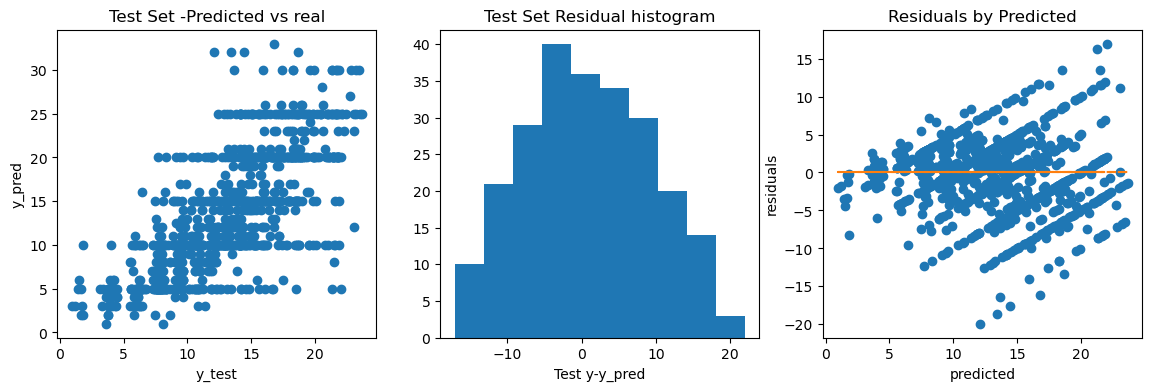

In [45]:
# Make a scatterplot of y_pred vs y
# Question: What kind of plot will you get if all the all the predictions are perfect?
# Answer: A straight line!

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_pred.to_numpy()-y_test.to_numpy(),"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<b>more fancy using seaborn

<Axes: >

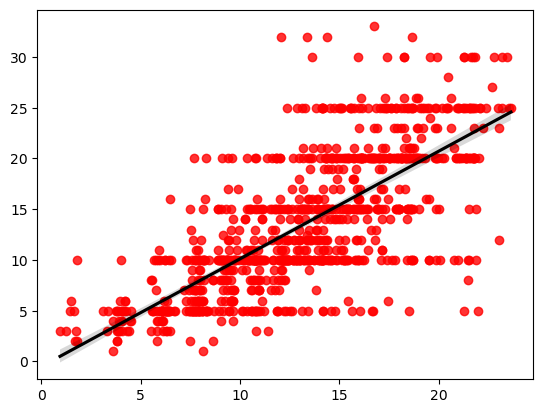

In [44]:
yp_ = y_pred.to_numpy()
yt_ = y_test.to_numpy()
sns.regplot(x=yp_,y=yt_,scatter_kws={"color": "red"}, line_kws={"color": "black"})

### Error metrics

In [46]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))
##prediction on the train set
print(mse(y_train,y_pred_train))

21.156064028533784
3.4803879899999686
23.330333925024917


In [47]:
R2=r2_score(y_test,y_pred)
R2

0.536916468981884

In [48]:
R2_test=model.score(X_test_ct,y_test)
R2_train=model.score(X_train_ct,y_train)
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.49807395058493975

## Feature Importances

In [53]:
feature_importances = pd.DataFrame(data={
    'Variable': X_train_ct.columns,
    'Importance': (model.coef_.reshape(len(X_train_ct.columns),))
})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances

,Variable,Importance
4,4,4.554051
2,2,0.249840
3,3,0.226248
0,0,-0.064720
1,1,-0.111025


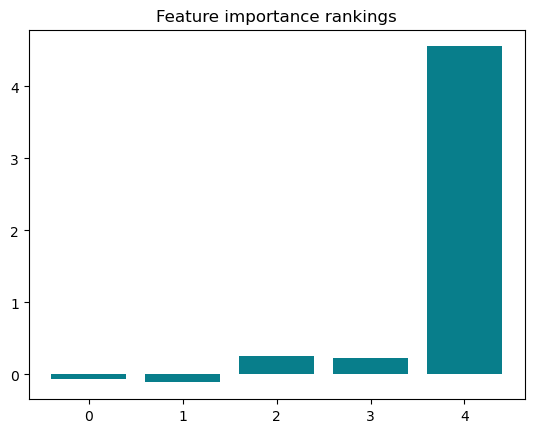

In [54]:
plt.bar(x=feature_importances['Variable'].iloc[:10], height=feature_importances['Importance'].iloc[:10], color='#087E8B')
plt.title('Feature importance rankings', size=12)
plt.xticks(rotation='horizontal')
plt.show()